In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal

# Anomaly Detection with **Probability Density Estimation**

In this notebook, we illustrate one of the simplest algorithms for **anomaly detection**, specifically an algorithm based on **probability density estimation**. First, let's introduce the problem with some basic definitions and examples. Imagine you are the owner of a company that produces airplane engines. Generally, your company performs exceptionally well, producing compliant and well-performing engines. However, in some rare cases, an engine may have small defects that can lead to significant anomalies and malfunctions. These cases are rare but possible. Preliminary analysis indicates that parameters such as temperature, fuel flow, and vibrations can help identify these defects and anomalies. Therefore, you want to set up a system to intelligently detect potential anomalies in your engines during the testing phase before selling them. This is where anomaly detection comes in! 

The idea is to examine the distribution of points (in this case, the engines) in the *feature space*, which are assumed to be numerical. "Good" engines are expected to "cluster" together, all characterized by the optimal vibrations, temperatures, and fuel flow parameters for a well-performing airplane engine. In contrast, "bad" engines are more likely to be apart in the feature space, appearing as **outliers**. If we have few features, such as 2 or 3, we may identify these outliers by simply visually inspecting the feature space. However, for more complex datasets with many features, this approach is impractical, and we need a more rigorous method. The simplest solution to this problem involves analyzing the data distribution: if data points follow a certain distribution, such as a Gaussian distribution in most cases, we can estimate this probability distribution from a sample of data points. Then, we can use this estimated probability distribution to detect outliers: if a new data point, i.e., a combination of new feature values, is expected to occur with very low probability according to the estimated distribution, we can consider that data point an "anomaly."

In [3]:
df = pd.read_csv("../datasets/anomaly-detection-sample-dataset.csv")

In [4]:
df

,f1,f2,f3,label
0,0.827183,1.246085,0.997129,0.0
1,0.120296,1.278452,3.219158,0.0
2,-1.124642,-1.359856,1.458081,0.0
3,-0.012247,1.453384,3.127197,0.0
4,0.971571,-0.446434,4.005771,0.0
...,...,...,...,...
495,-0.759133,1.188393,0.680081,0.0
496,2.092387,0.082284,0.824211,0.0
497,0.322719,1.189017,4.235426,0.0
498,0.813517,-0.426881,1.987068,0.0


In [5]:
df.shape

(500, 4)

In [6]:
tot_point = df.shape[0]

In [7]:
# Fraction of outliers
num_outliers = df[df["label"]==1].shape[1]

In [8]:
# Percentage outliers
perc_outliers = num_outliers/tot_point*100
print(f"The % of Outliers in this dataset is: {perc_outliers}")

The % of Outliers in this dataset is: 0.8


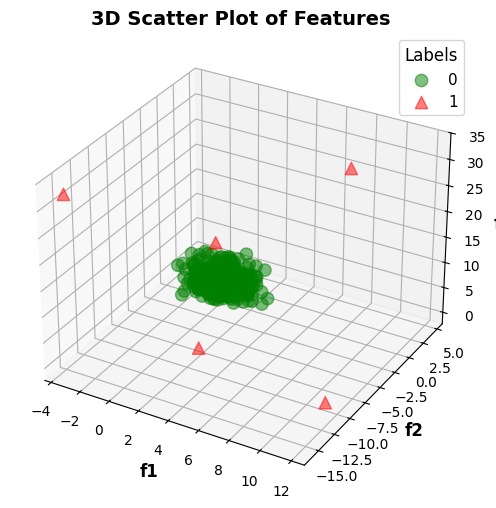

In [9]:
# Create a figure and a 3D axis
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each group separately to add a legend
for label, color, marker in zip([0, 1], ['green', 'red'], ['o', '^']):
    subset = df[df['label'] == label]
    ax.scatter(subset['f1'], subset['f2'], subset['f3'], 
               c=color, marker=marker, s=80, alpha=0.5, label=f'{label}')

# Set labels and title with custom fonts
ax.set_xlabel('f1', fontsize=12, fontweight='bold')
ax.set_ylabel('f2', fontsize=12, fontweight='bold')
ax.set_zlabel('f3', fontsize=12, fontweight='bold')
ax.set_title('3D Scatter Plot of Features', fontsize=14, fontweight='bold')

# Add a legend
ax.legend(title='Labels', title_fontsize='12', fontsize='11')

# Customize grid lines
ax.grid(color='white', linestyle='-', linewidth=1, alpha=0.7)

# Show the plot
plt.show()

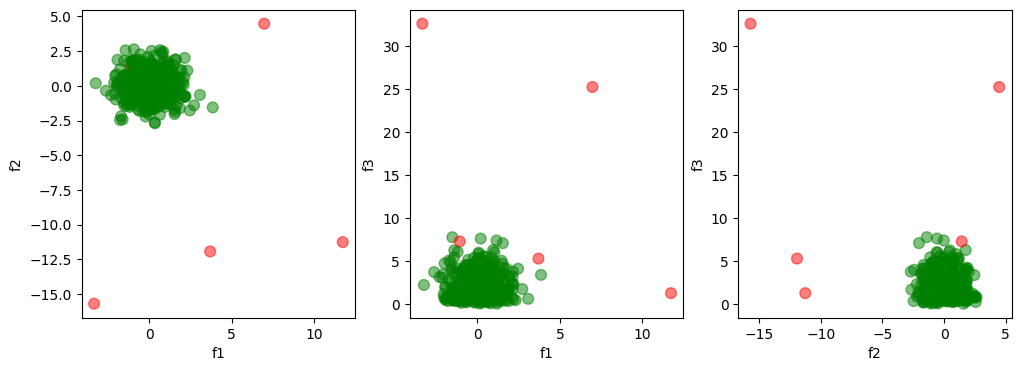

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

colors = df['label'].map({0: 'green', 1: 'red'})

df.plot(kind="scatter", x='f1', y='f2', ax=ax[0], c=colors, alpha=0.5, s=60)
df.plot(kind="scatter", x='f1', y='f3', ax=ax[1], c=colors,  alpha=0.5, s=60)
df.plot(kind="scatter", x='f2', y='f3', ax=ax[2], c=colors,  alpha=0.5, s=60)

plt.show()

## Data Preparation

In [11]:
def sturges_bins(df_feat):
    n = len(df_feat)
    return int(np.ceil(np.log2(n) + 1))

In [12]:
def sample_mean(df_feat):
    return np.mean(df_feat)

In [13]:
def sample_variance(df_feat):
    
    n = len(df_feat)
    mean = sample_mean(df_feat)

    return (1/(n-1))*np.sum((df_feat-mean)**2, axis=0)

In [14]:
def gaussian(x, mu, sigma):
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2/(2*sigma**2))

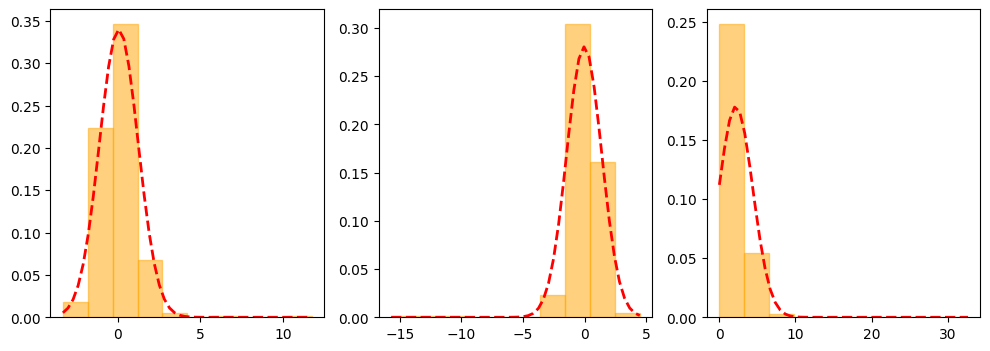

In [15]:
# Plotting each feature distribution
fig, ax = plt.subplots(1, 3, figsize=(12,4))

x_feats = [np.linspace(min(df[i]), max(df[i])) for i in ["f1", "f2", "f3"]]
    

ax[0].hist(x=df["f1"], bins=sturges_bins(df["f1"]), color="orange", edgecolor="orange", alpha=0.5, density=True)
ax[0].plot(
    x_feats[0],
    gaussian(x_feats[0],
             sample_mean(df["f1"]), 
             np.sqrt(sample_variance(df["f1"]))), 
    color="red", lw=2, ls="--")


ax[1].hist(x=df["f2"], bins=sturges_bins(df["f2"]), color="orange", edgecolor="orange", alpha=0.5, density=True)
ax[1].plot(
    x_feats[1],
    gaussian(x_feats[1],
             sample_mean(df["f2"]), 
             np.sqrt(sample_variance(df["f2"]))), 
    color="red", lw=2, ls="--")


ax[2].hist(x=df["f3"], bins=sturges_bins(df["f3"]), color="orange", edgecolor="orange", alpha=0.5, density=True)
ax[2].plot(
    x_feats[2],
    gaussian(x_feats[2],
             sample_mean(df["f3"]), 
             np.sqrt(sample_variance(df["f3"]))), 
    color="red", lw=2, ls="--")

plt.show()

From the above plots, we can see the first and second feature display a Gaussian distribution, while the third feature `f3` is right-skewed. Since it is strictly positive, we can apply a log transformation to make it more gaussian-like:

In [16]:
df["f3"].min()

np.float64(0.0459189761095633)

In [17]:
df_base = df.copy()

In [18]:
df_base["f3"] = df_base["f3"].apply(lambda x: np.log(x+1))

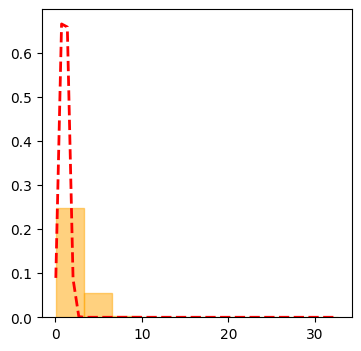

In [19]:
# Plotting each feature distribution
fig, ax = plt.subplots(figsize=(4,4))

x_f3 = np.linspace(min(df["f3"]), max(df["f3"]))

ax.hist(x=df["f3"], bins=sturges_bins(df_base["f3"]), color="orange", edgecolor="orange", alpha=0.5, density=True)
ax.plot(
    x_f3,
    gaussian(x_f3,
             sample_mean(df_base["f3"]), 
             np.sqrt(sample_variance(df_base["f3"]))), 
    color="red", lw=2, ls="--")

plt.show()

Now, we will split the base dataframe into two dataset:

- **`train` dataset**: a training set on which we will estimate the multivariate density distribution; this set will contain *only inliers points (label=0)*;
- **`validation` dataset**: a validation set on which we will perforrm a sort of hyperparameter tuning; indeed, on this set, that will contain all the *outliers* in our data, we will look for the best value of the $\epsilon$ threshold to use for the anomaly detection itself.

We will adopt a rather standard proportion between train and validation set, namely **80% of data (label=0)** will be used for the training set, and the other **20%** for the validation.

In [20]:
label0 = df_base[df_base["label"] == 0]
label1 = df_base[df_base["label"] == 1]

In [21]:
train_label0, val_label0 = train_test_split(label0, test_size=0.2, random_state=42)

In [22]:
# Combine the test set of label 0 with all data of label 1
df_val = pd.concat([val_label0, label1])

In [23]:
df_train = train_label0.copy()

In [24]:
# Check proportions
num_val = len(df_val)
num_train = len(df_train)

print(f"Proportion of X_train: {num_train/(num_val+num_train)*100}%")
print(f"Proportion of X_test: {num_val/(num_val+num_train)*100}%")

Proportion of X_train: 79.2%
Proportion of X_test: 20.8%


## Training and Hyperparameter Tuning

In [25]:
feature_cols = ["f1", "f2", "f3"]
label_col = ["label"]

In [26]:
X_train, y_train = df_train[feature_cols], df_train[label_col]
X_val, y_val = df_val[feature_cols], df_val[label_col]

In [71]:
class AnomalyDetection:
    def __init__(self, n_steps):
        self.n_steps = n_steps
        self.labels = np.array([['True Negative', 'False Positive'], 
                       ['False Negative', 'True Positive']]
                     )

    @staticmethod
    def estimate_gaussian(X_train):
        '''
        Function to estimate the Gaussian distribution, computing sample mean and sample variance
        '''
    
        # Conver to a Numpy Array
        features = X_train.to_numpy()
    
        m, n = features.shape
        
        mean = np.mean(features, axis=0)
        variance = 1/(m+1)*np.sum((features-mean)**2, axis=0)
        return mean, variance

    @staticmethod
    def compute_scores(cm):
        tn, fp, fn, tp =  cm.ravel().tolist()
    
        precision = tp/(tp+fp) if tp+fp!=0 else 0 
        recall = tp/(tp+fn) if tp+fn!=0 else 0 
        F1 = (2*precision*recall)/(precision+recall) if precision+recall!=0 else 0 
    
        return precision, recall, F1

    @staticmethod
    def label_prediction(pred):
            return [1 if x else 0 for x in pred]

    def get_density_estimation(self, X_train):

        mean, variance = self.estimate_gaussian(X_train)

        self.p_density_ = multivariate_normal(mean, variance).pdf
        
        return None

    def threshold_tune(self, X_val, y_val):

        p_val = self.p_density_(X_val.to_numpy())
        
        step_size = (max(p_val) - min(p_val)) / self.n_steps
    
        thresholds = np.arange(min(p_val), max(p_val), step_size)
        
        y_preds = [ self.label_prediction((p_val < threshold)) for threshold in thresholds]
    
        
        cms = [confusion_matrix(y_val, y_pred) for y_pred in y_preds]
    
        F1_scores = [self.compute_scores(cm)[2] for cm in cms]
    
        best_param = np.argmax(np.array(F1_scores))

        self.best_params_ = {
            "threshold": thresholds[best_param], 
            "confusion_matrix": cms[best_param], 
            "F1_score": F1_scores[best_param]
        }
    
        return None

    def predict(self, X_new):
        return self.p_density_(X_new.to_numpy())<self.best_params_["threshold"]
        

    def plot_confusion_matrix(self, cm):
        
        n_rows, n_columns = cm.shape[0], cm.shape[1]
    
        custom_annotations = np.array(
                [f'{cm[i, j]}\n{self.labels[i, j]}' for i in range(n_rows) for j in range(n_columns)]
        )
    
        fig, ax = plt.subplots(figsize=(5,5))
    
        hm = sns.heatmap(cm, 
                         annot=custom_annotations.reshape(n_rows, n_columns), 
                         annot_kws={"weight": "bold"},
                         fmt='', cmap='Blues',                      
                         xticklabels=['Predicted 0', 'Predicted 1'], 
                         yticklabels=['Actual 0', 'Actual 1'],
                         ax=ax
                        )
        ax.set_title('Confusion Matrix')
        plt.show()

In [72]:
anomalyDet = AnomalyDetection(n_steps=1000)

In [73]:
anomalyDet.get_density_estimation(X_train)

In [74]:
p = anomalyDet.p_density_

In [75]:
# Computing the density on the X_val values
p_val = p(X_val.to_numpy())

In [76]:
p_val.shape

(104,)

Let's first making the predictions using a given threshold $\epsilon$:

In [77]:
epsilon = 0.01

In [78]:
pred = (p_val < epsilon)

In [79]:
pred

array([False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
        True, False,  True, False, False, False, False, False, False,
        True,  True,  True,  True,  True])

In [80]:
y_pred = [1 if x else 0 for x in pred]

In [81]:
cm = confusion_matrix(y_val, y_pred)

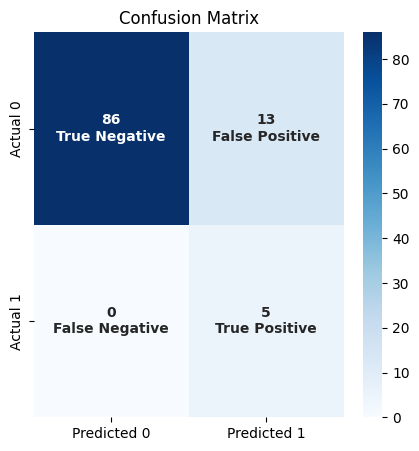

In [82]:
anomalyDet.plot_confusion_matrix(cm)

In [83]:
anomalyDet.threshold_tune(X_val, y_val)

In [84]:
best_threshold = anomalyDet.best_params_["threshold"]
best_cm = anomalyDet.best_params_["confusion_matrix"]

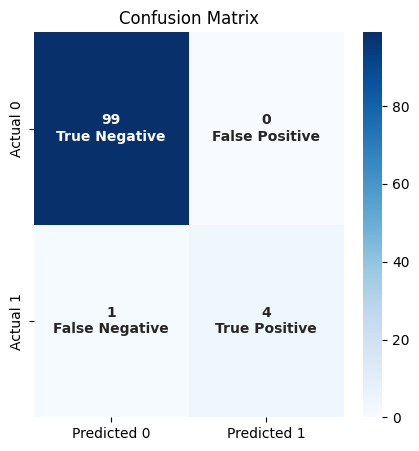

In [85]:
anomalyDet.plot_confusion_matrix(best_cm)

In [94]:
anomalyDet.predict(
    pd.DataFrame([(10, 10, 10)])
)

np.True_